In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load as module

In [8]:
sys.path.append('../mockmodel/')
from TracerFit import mwfit, int_idx

In [18]:
run_id=1
size = 1000
file = "gaia_edr3.gaia_source_b80"

model = {}
for cardinal in ['north', 'south']:
    model[cardinal] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_sf_perr_{run_id:03d}.h')

# Load data

In [15]:
model_n.sample['source_id']

array([3948655016249030528, 3948923189710962560, 3948862755226655104,
       3948765547231037696, 3948560213435211904, 3947621196145038720,
       3947860649161686016, 3947559898371696768, 3935492483379068416,
       3935507258066652032, 3947619065841704704, 3947613499563456128,
       3935996368942574336, 3947920538185718784, 3948691776872677120,
       3948665255450771456, 3947896456305725824, 3948800113127898368,
       3948803755260411264, 3949185698112485248, 3949380071152535808,
       3949125263628103168, 3948099724220992256, 3948078146305929344,
       3948477238962451840, 3948210401233514496, 3948403979704540160,
       3948216375532703232, 3948433254201206400, 3935655318474238208,
       3934981863306995712, 3935908648529712128, 3936006951741700096,
       3935826494396188672, 3936015782194503168, 3936019458686553856,
       3935820618880872064, 3934717606855744640, 3934931698089900544,
       3935761490065467392, 3935010038293009408, 3935768735679658112,
       3941010382482

In [20]:
# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/{file}.h'
with h5py.File(filename, 'r') as hf:
    for cardinal in ['north', 'south']:
        subset = np.intersect1d(hf[cardinal]['source_id'][...], model[cardinal].sample['source_id'], return_indices=True)[1]
        for key in hf[cardinal].keys():
            sample[cardinal][key]=hf[cardinal][key][...][subset]

In [21]:
for cardinal in ['north', 'south']:
    model[cardinal]._generate_fid_pars()
#model[cardinal].sample=sample

Got Selectionfunction pars
Got Selectionfunction pars


# Plot results

In [50]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [51]:
model['north'].free_pars, model['north'].fixed_pars

({0: array(['w', 'hz', 'fD'], dtype='<U20'),
  1: array(['w', 'hz', 'fD'], dtype='<U20'),
  2: array(['w', 'hz', 'fD'], dtype='<U20'),
  'shd': array(['alpha1', 'alpha2'], dtype='<U20')},
 {0: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.6)},
  1: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.73)},
  2: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.64)},
  'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mx': array(12),
  'R0': array(8.27),
  'theta_deg': array(80)})

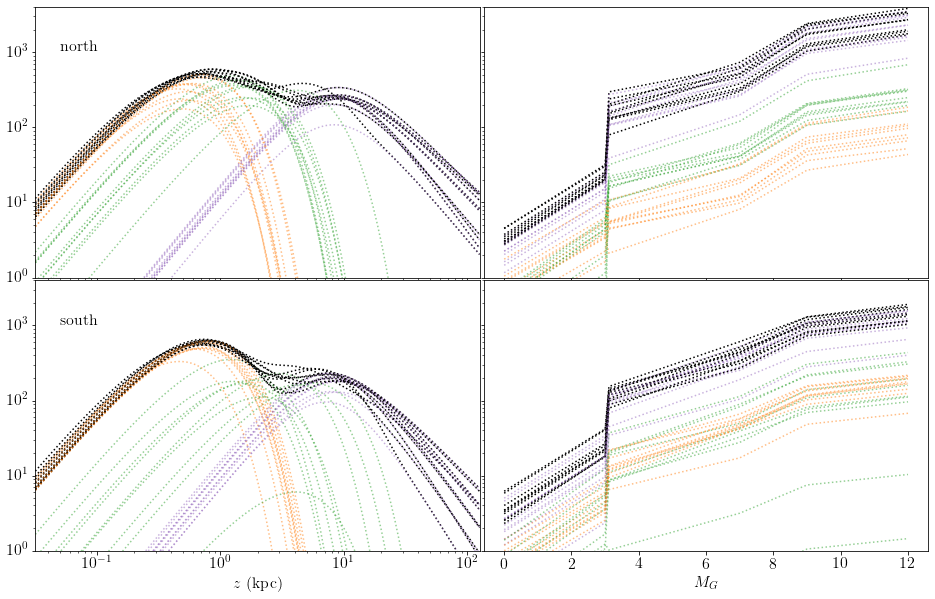

In [52]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','alpha':1, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.5, 'linestyle':':'})

cardinals = ['north', 'south']
label = 'sf_perr_mcmc'

for jj, cardinal in enumerate(cardinals):
    fixed_pars = model[cardinal].fixed_pars
    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain'][label].shape
    flat_chain = model[cardinal].mcmc_results['chain'][label][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    plt.xlim(10**zlim[0],10**zlim[1])
    #plt.legend()
    plt.text(0.05,1000,cardinal)

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([fixed_pars['Mx'], fixed_pars['Mms'], fixed_pars['Mms1'], 
                                        fixed_pars['Mms2']])))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 


plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.ylim(1.,4000)#100000000)

plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [53]:
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

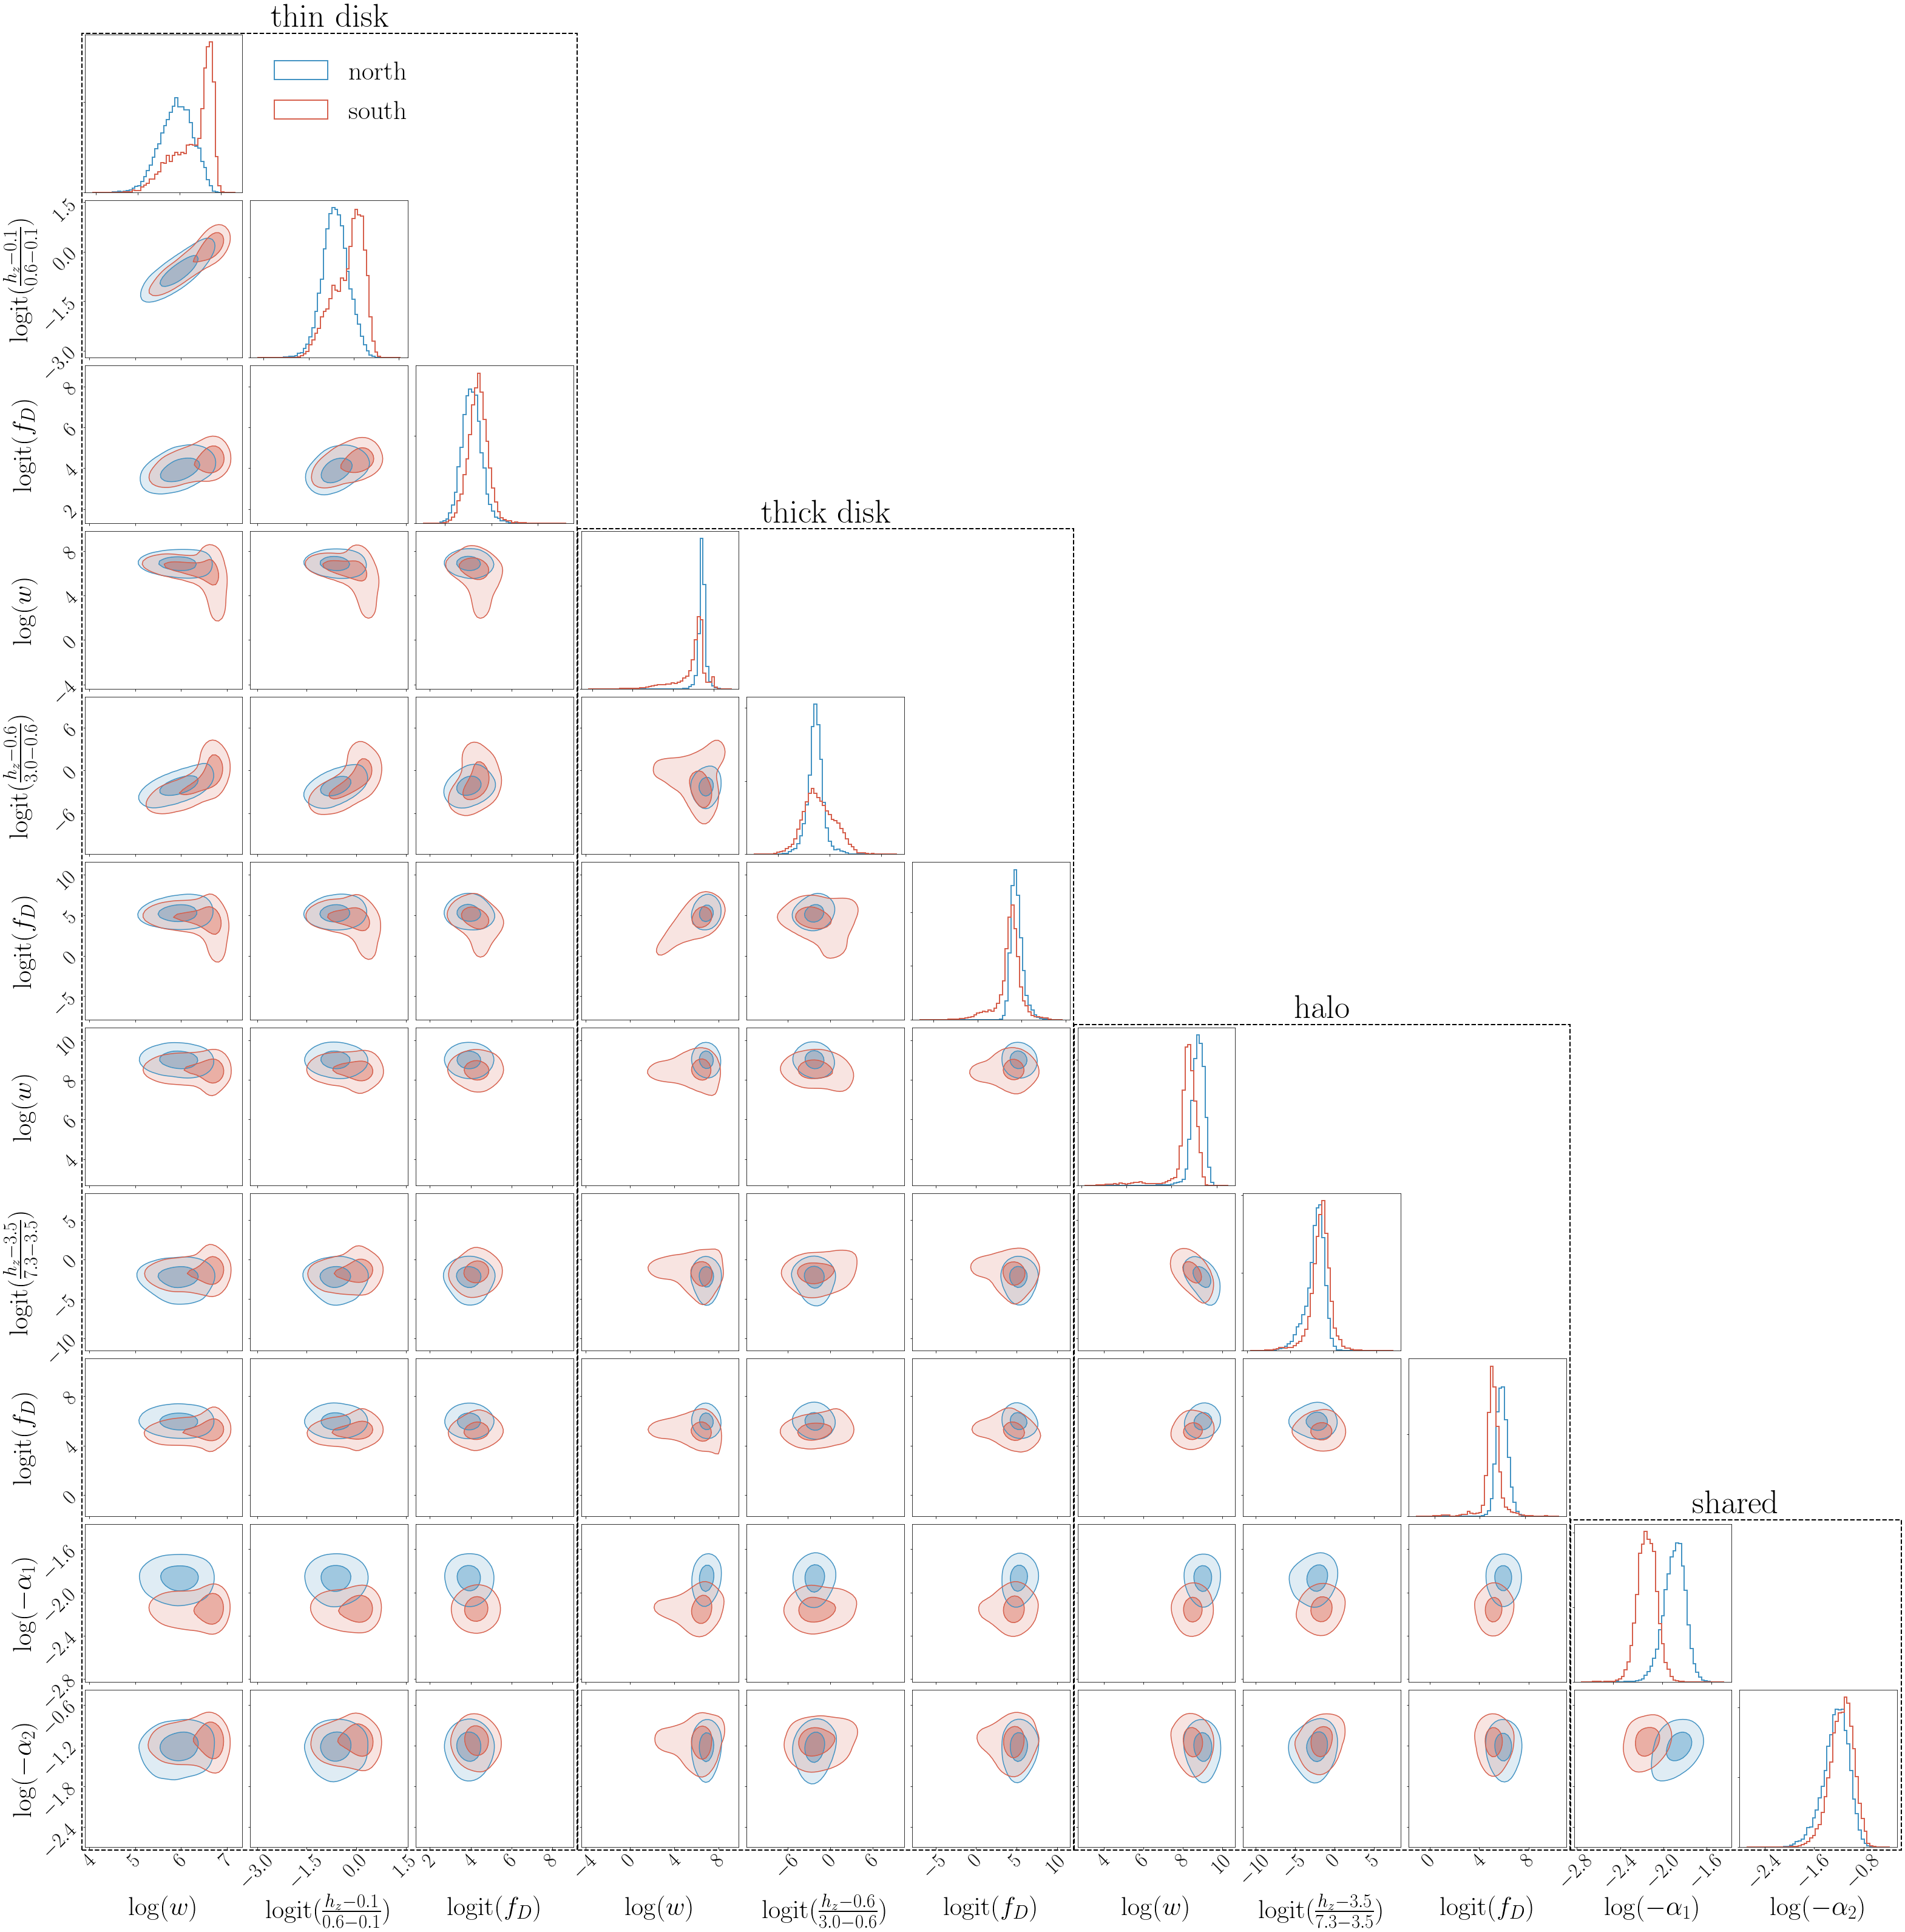

In [54]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model['north'].mcmc_results['chain']['sf_perr_mcmc'],
                          model['south'].mcmc_results['chain']['sf_perr_mcmc']], 
                         index=cardinals, hist_kwargs={'linewidth':2}, 
                         labels=model['north'].get_labels(),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

In [55]:
model['north']._generate_fid_pars()
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

labels=[];
for cmpt in np.arange(len(model['north'].components)).tolist()+['shd',]:
    for par in model['north'].free_pars[cmpt]:
        labels+=[label_dict[par],]

Got Selectionfunction pars


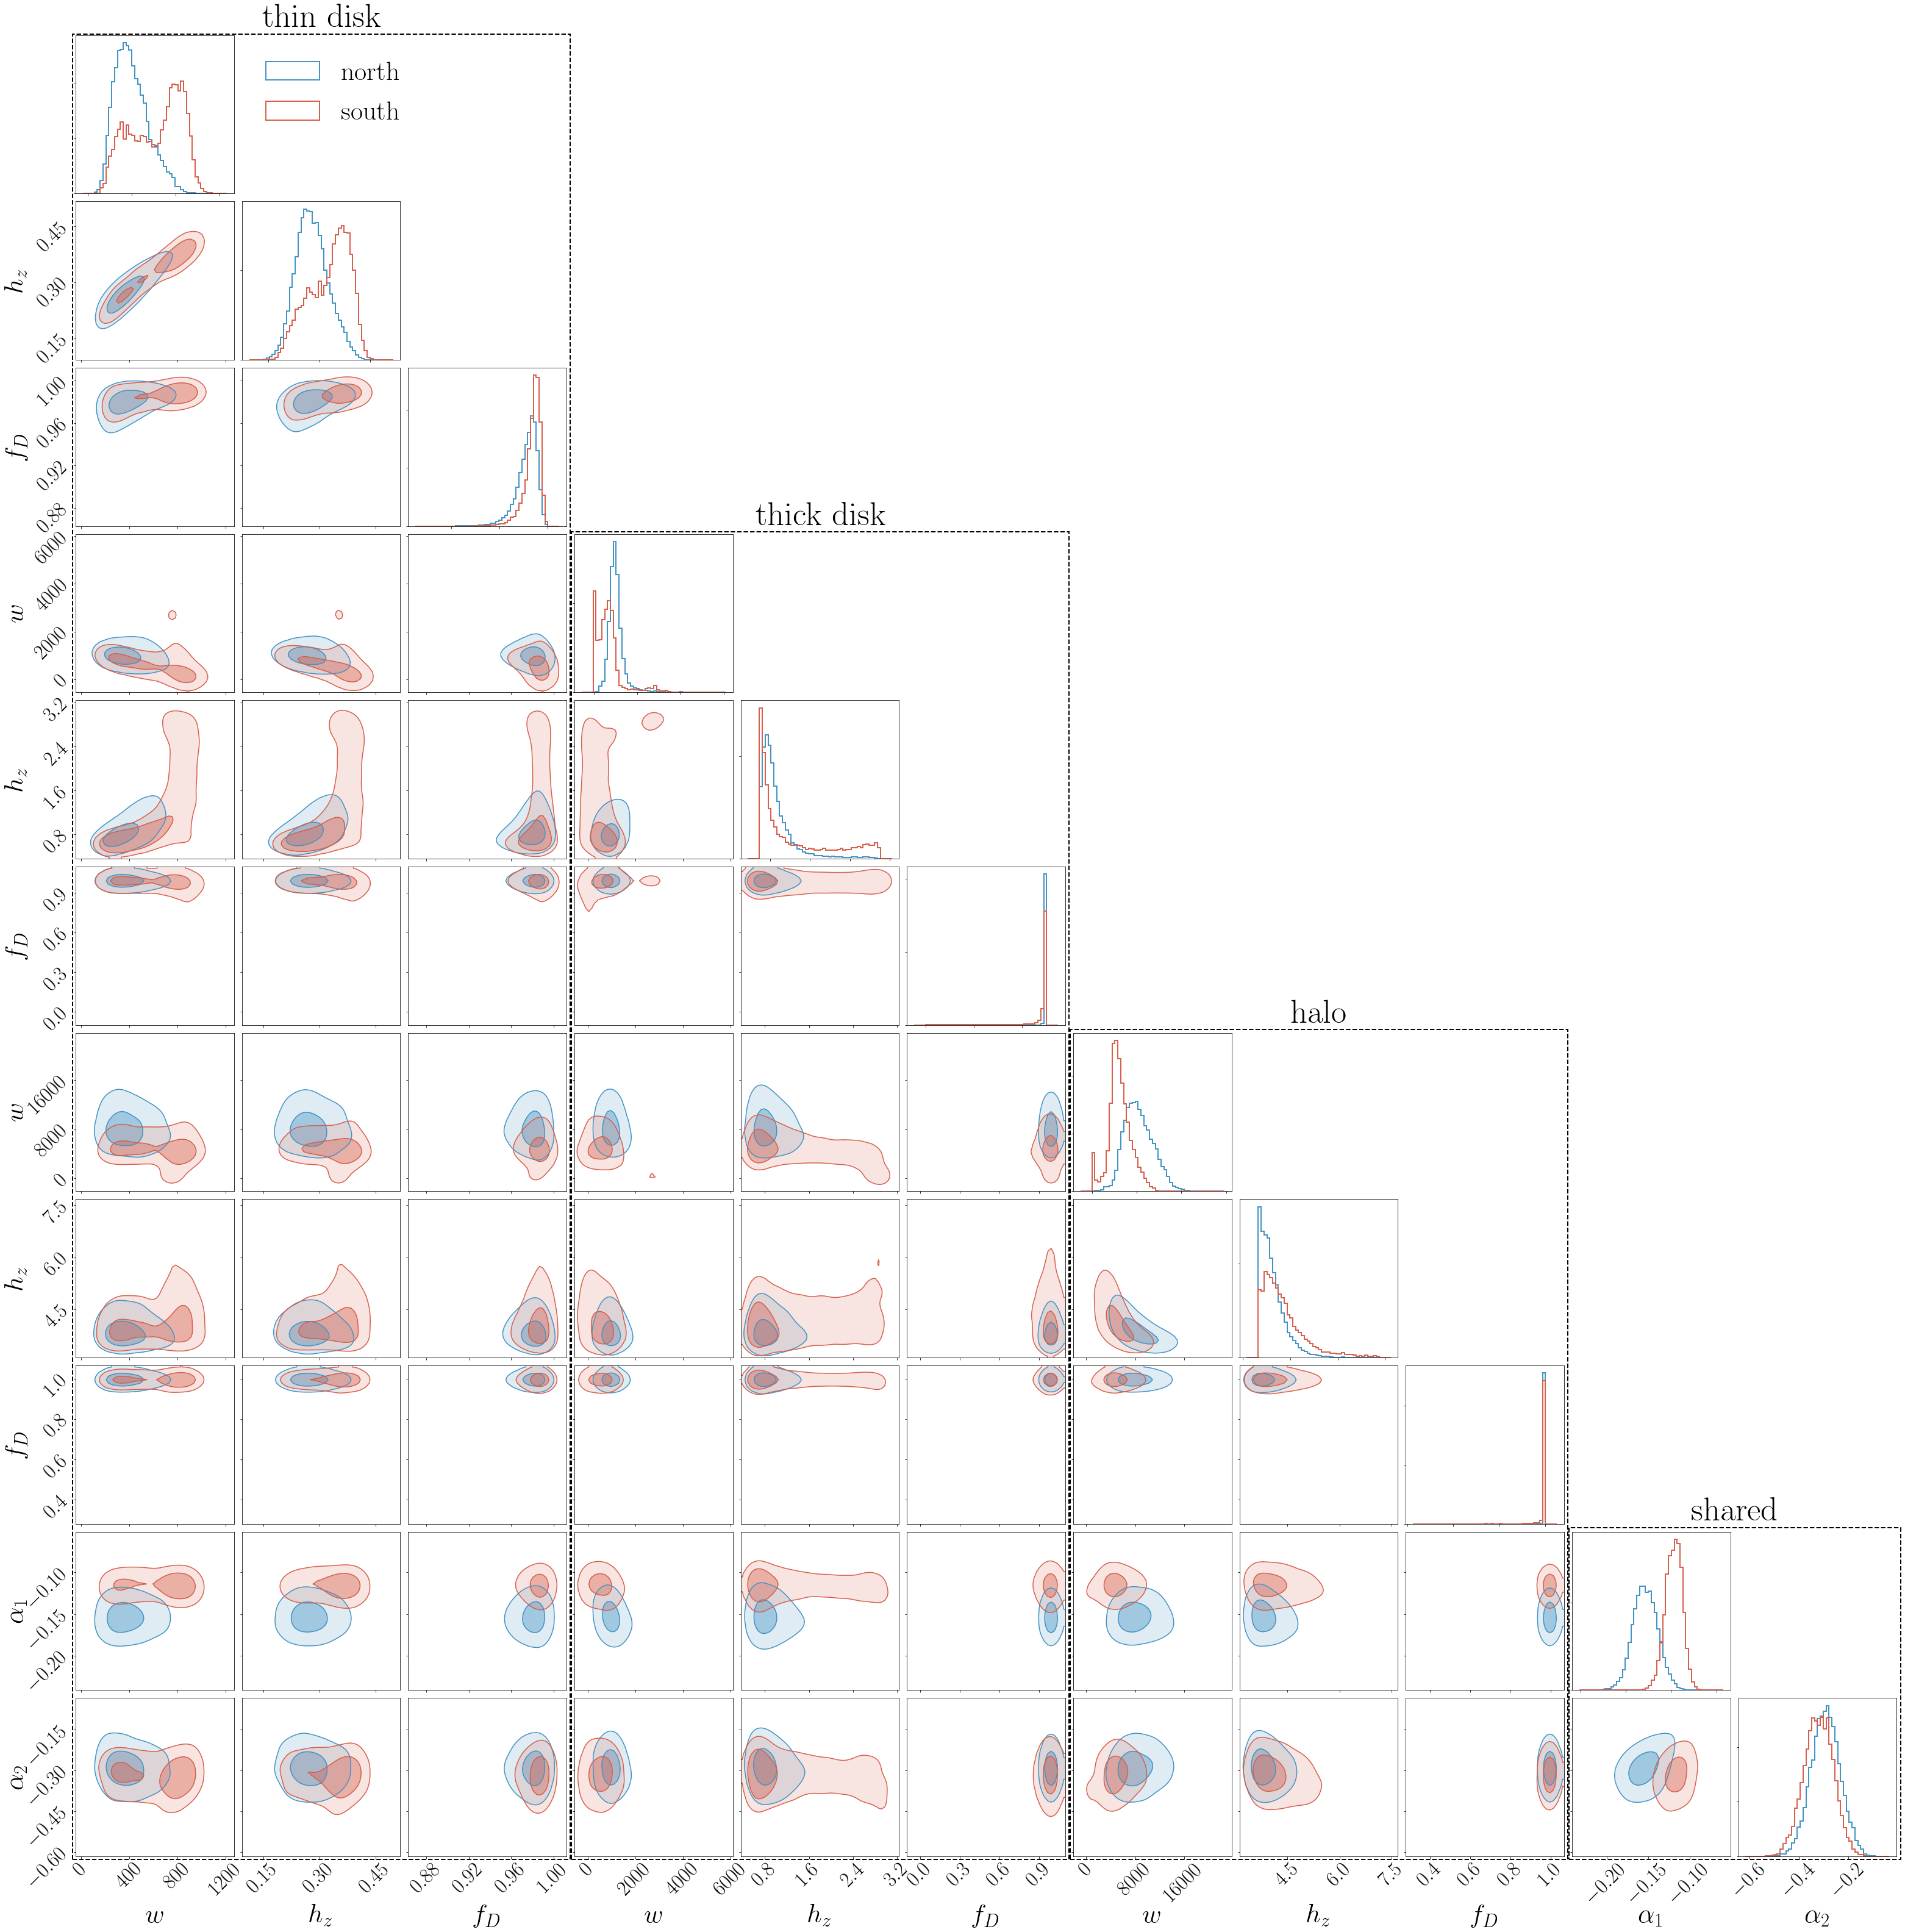

In [57]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model['north'].mcmc_results['chain']['sf_perr_mcmc'],
                          model['south'].mcmc_results['chain']['sf_perr_mcmc']], 
                         index=cardinals, hist_kwargs={'linewidth':2}, 
                         labels=labels, functions=functions,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)